# California Pacific Ocean Sound Recordings
https://registry.opendata.aws/pacific-sound/

FILES TOO BIG: 

In [1]:
# get data from 2021

In [58]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import scipy
from scipy import signal, interpolate
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import s3fs
import botocore
import os
import glob

In [9]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='', 
    config=Config(signature_version=UNSIGNED))

In [10]:
bucket = 'pacific-sound-256khz-2021'

for i, obj in enumerate(s3.list_objects_v2(Bucket=bucket)['Contents']):
  print(obj['Key'])
  if i > 20:
      break

01/MARS_20210101_000424.wav
01/MARS_20210101_001424.wav
01/MARS_20210101_002424.wav
01/MARS_20210101_003424.wav
01/MARS_20210101_004424.wav
01/MARS_20210101_005424.wav
01/MARS_20210101_010424.wav
01/MARS_20210101_011424.wav
01/MARS_20210101_012424.wav
01/MARS_20210101_013424.wav
01/MARS_20210101_014424.wav
01/MARS_20210101_015424.wav
01/MARS_20210101_020424.wav
01/MARS_20210101_021424.wav
01/MARS_20210101_022424.wav
01/MARS_20210101_023424.wav
01/MARS_20210101_024424.wav
01/MARS_20210101_025424.wav
01/MARS_20210101_030424.wav
01/MARS_20210101_031424.wav
01/MARS_20210101_032424.wav
01/MARS_20210101_033424.wav


In [13]:
bucket = 'pacific-sound-256khz-2021'
filename = '01/MARS_20210101_000424.wav'
url = f'https://{bucket}.s3.amazonaws.com/{filename}'
#print(f'Reading metadata from {url}')
#sf.info(io.BytesIO(urlopen(url).read()), verbose=True)

In [42]:
# Fetch all urls
s3 = s3fs.S3FileSystem(anon=True)

# List the files available
audio_files = s3.ls("pacific-sound-256khz-2021/01")

In [51]:
### This is taking ages... why???
%%prun
with s3.open(audio_files[0]) as f:
    x, sample_rate = sf.read(io.BytesIO(f.read()),dtype='float32')

In [64]:
# To save the files on disk
s3 = s3fs.S3FileSystem(anon=True)
bucket_name = 'pacific-sound-256khz-2021'
fp = s3.glob(f"{bucket_name}/**/*.wav")[::20]

In [63]:
fp

['pacific-sound-256khz-2021/01/MARS_20210101_000424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210101_164424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210102_092424.wav',
 'pacific-sound-256khz-2021/01/MARS_20210103_020423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210103_184423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210104_112423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210105_040423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210105_204423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210106_132423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210107_060423.wav',
 'pacific-sound-256khz-2021/01/MARS_20210107_224413.wav',
 'pacific-sound-256khz-2021/01/MARS_20210108_152413.wav',
 'pacific-sound-256khz-2021/01/MARS_20210109_080413.wav',
 'pacific-sound-256khz-2021/01/MARS_20210110_004413.wav',
 'pacific-sound-256khz-2021/01/MARS_20210110_172413.wav',
 'pacific-sound-256khz-2021/01/MARS_20210111_100413.wav',
 'pacific-sound-256khz-2021/01/MARS_20210112_024413.wav',
 'pacific-soun

In [53]:
for f in fp:
    file_name = os.path.basename(f)
    out_file = f'data/california-pam/{file_name}'
    client.download_file(
        Bucket=bucket_name,
        Key=os.path.relpath(f, bucket_name),
        Filename=out_file
    )

AttributeError: 'str' object has no attribute 'objects'

In [45]:
# convert scaled voltage to volts
v = x*3 
nsec = (v.size)/sample_rate # number of seconds in vector
spa = 1  # seconds per average
nseg = int(nsec/spa)
print(f'{nseg} segments of length {spa} seconds in {nsec} seconds of audio')

600 segments of length 1 seconds in 600.0 seconds of audio


In [46]:
# initialize empty LTSA
nfreq = int(sample_rate/2+1)
nfreq,nseg
sg = np.empty((nfreq, nseg), float)
sg.shape

(128001, 600)

In [47]:
# get window for welch
w = scipy.signal.get_window('hann',sample_rate)

# process spectrogram
for x in range(0,nseg):
  cstart = x*spa*sample_rate
  cend = (x+1)*spa*sample_rate
  f,psd = scipy.signal.welch(v[cstart:cend],fs=sample_rate,window=w,nfft=sample_rate)
  psd = 10*np.log10(psd)
  sg[:,x] = psd

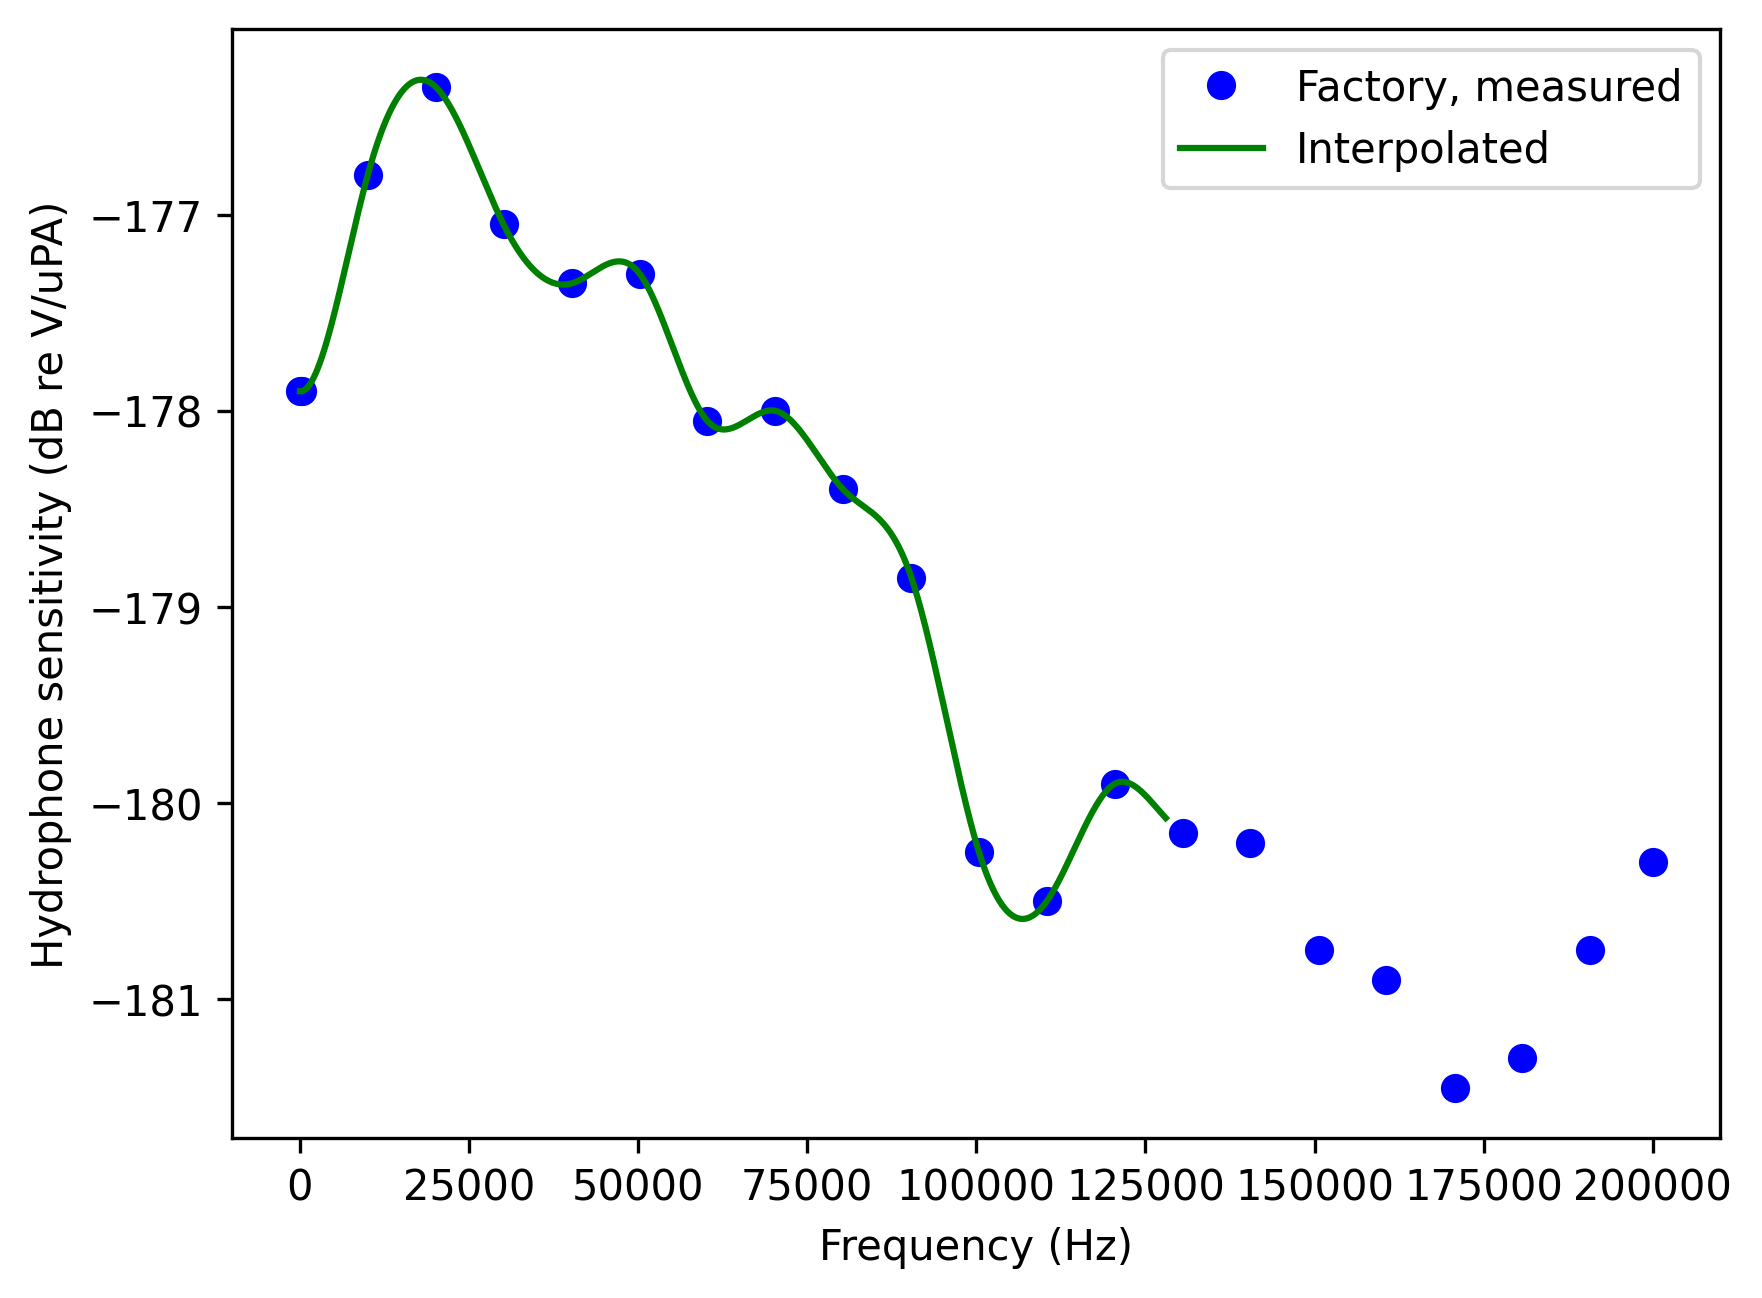

In [48]:
# define hydrophone calibration data
calfreq = [0,250,10000,20100,30100,40200,50200,60200,70300,80300,90400,100400,110400,120500,130500,140500,150600,160600,170700,180700,190700,200000]
calsens = [-177.90,-177.90,-176.80,-176.35,-177.05,-177.35,-177.30,-178.05,-178.00,-178.40,-178.85,-180.25,-180.50,-179.90,-180.15,-180.20,-180.75,-180.90,-181.45,-181.30,-180.75,-180.30]

# interpolate to the frequency resolution of the spectrogram
tck = interpolate.splrep(calfreq, calsens, s=0)
isens = interpolate.splev(f, tck, der=0)
plt.figure(dpi=300)
#im = plt.plot(calfreq,calsens,'bo',f,isens,'g') 
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('Hydrophone sensitivity (dB re V/uPA)')
#plt.legend(['Factory, measured', 'Interpolated'])

In [49]:
# replicate interpolated sensitivity
isensg = np.transpose(np.tile(isens,[nseg,1]))

(128001, 600)

Text(0.5, 1.0, 'Calibrated spectrum levels')

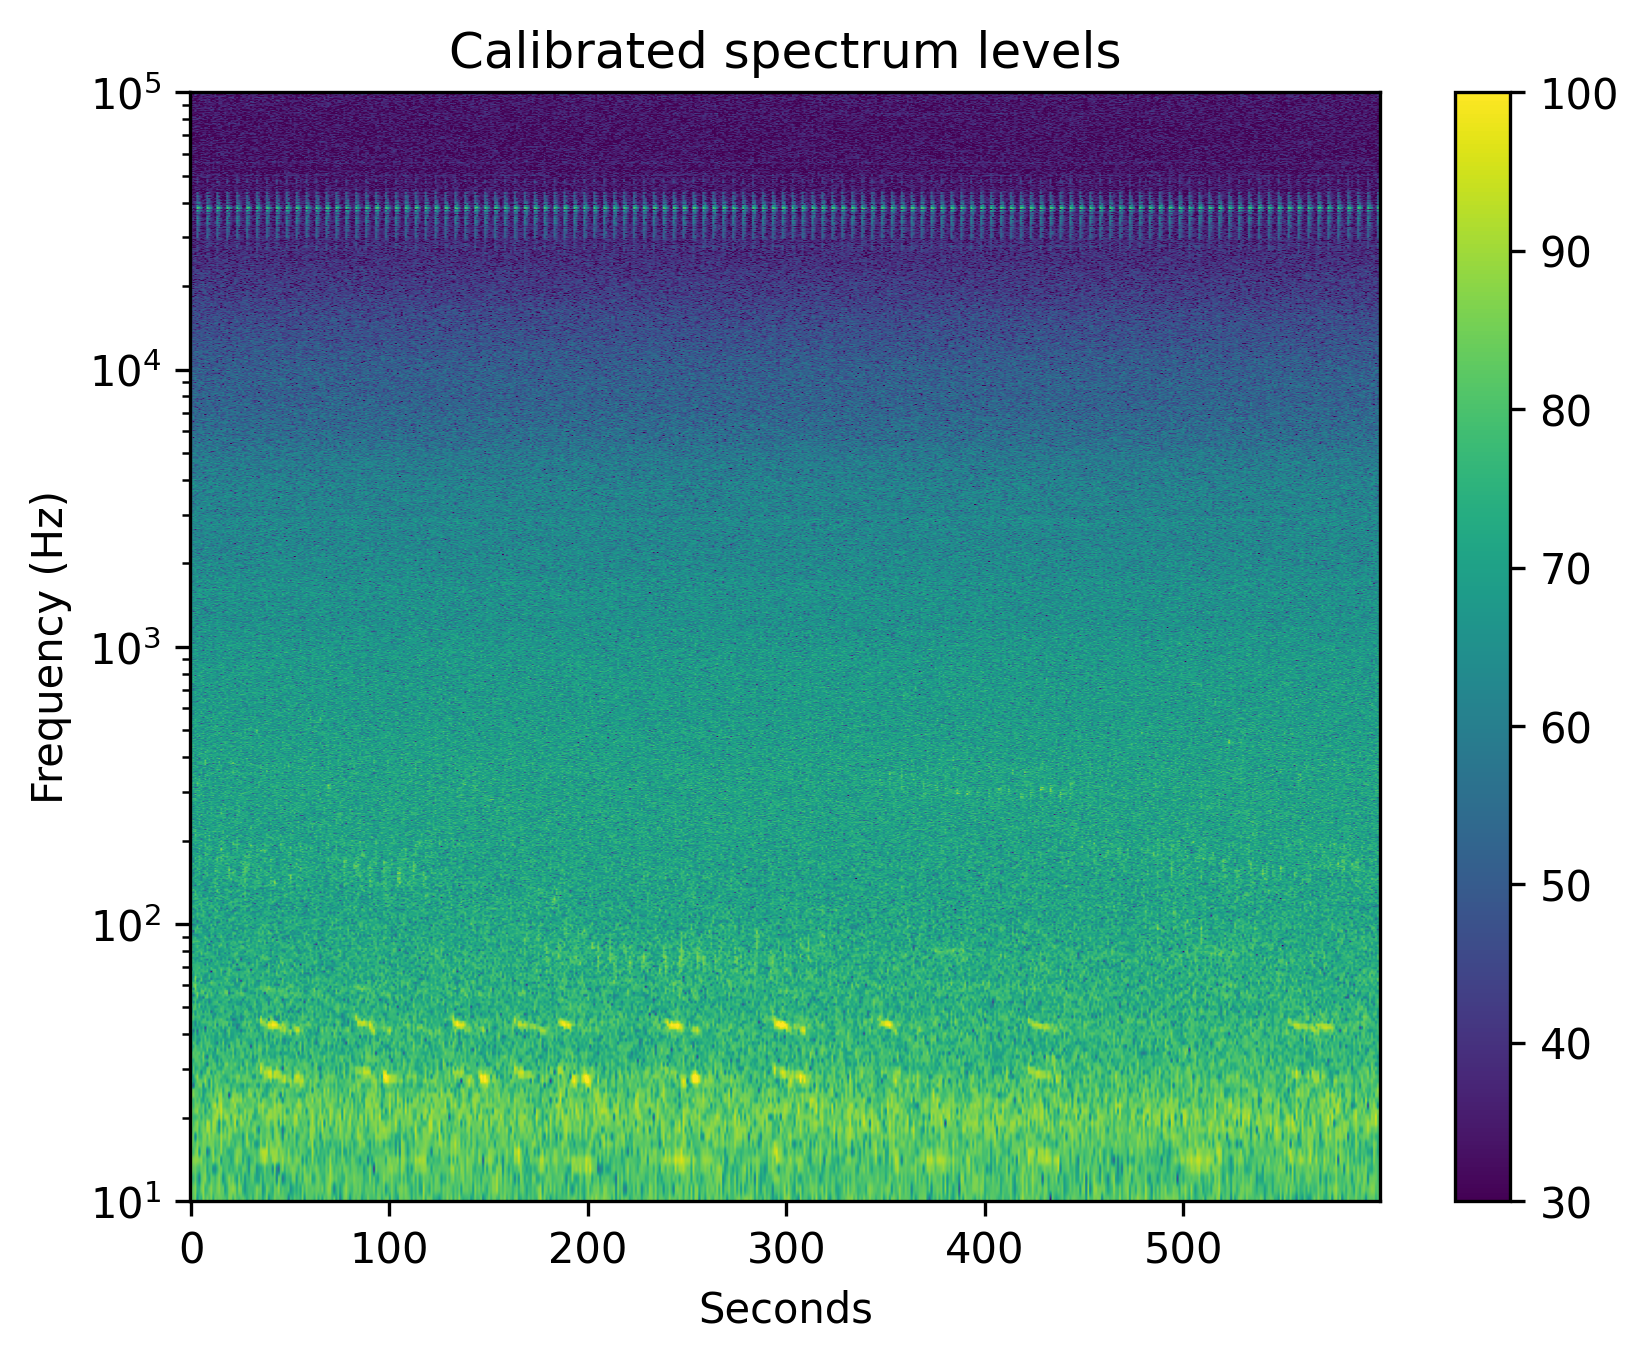

In [50]:
plt.figure(dpi=300)
im = plt.imshow(sg-isensg,aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,100000)
plt.colorbar(im)
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')